# Predicting COVID-19 cases with ARIMA and ANNs

## Importing Libraries

In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import statsmodels.api as sm
import math
import itertools
import warnings
warnings.filterwarnings("ignore")

## Data Handling

In [2]:
def preprocess(df):
    df = df.drop(["Lat", "Long"], axis=1)
    df = df.groupby(["Country/Region"], as_index=False).sum()
    df.loc[-1] = df.sum()
    df.loc[-1, "Country/Region"] = "Worldwide"
    countries = [
        "US",
        "Germany",
        "Spain",
        "United Kingdom",
        "France",
        "India",
        "Iran",
        "Italy",
        "Russia",
        "Turkey",
        #         "Worldwide",
    ]
    df = df.loc[df["Country/Region"].isin(countries)]
    df.reset_index(drop=True, inplace=True)
    df = df.set_index("Country/Region")
    df.columns = pd.to_datetime(df.columns)
    df = df.T
    return df

In [3]:
confirmed_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
)
confirmed_df = preprocess(confirmed_df)
deaths_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
)
deaths_df = preprocess(deaths_df)
recovered_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
)
recovered_df = preprocess(recovered_df)

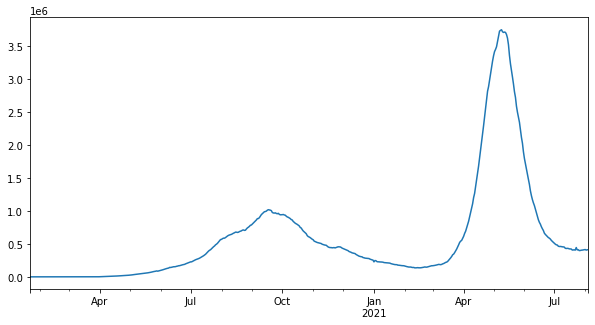

In [4]:
active_df = pd.DataFrame(confirmed_df - deaths_df - recovered_df)
active_df[:"2021-08-04"]['India'].plot(figsize=(10, 5))
plt.show()

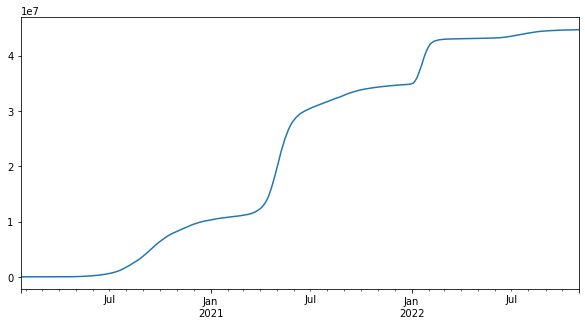

In [5]:
confirmed_df['India'].plot(figsize=(10, 5))
plt.show()

In [6]:
#deaths_df.plot(figsize=(10, 5))
#plt.show()

In [7]:
#recovered_df.plot(figsize=(10, 5))
#plt.show()

In [8]:
confirmed_df.head

<bound method NDFrame.head of Country/Region    France   Germany     India     Iran     Italy    Russia  \
2020-01-22             0         0         0        0         0         0   
2020-01-23             0         0         0        0         0         0   
2020-01-24             2         0         0        0         0         0   
2020-01-25             3         0         0        0         0         0   
2020-01-26             3         0         0        0         0         0   
...                  ...       ...       ...      ...       ...       ...   
2022-10-27      36964789  35523412  44649088  7557134  23475187  21097662   
2022-10-28      36990572  35571130  44650662  7557240  23504224  21105179   
2022-10-29      36990572  35571130  44652256  7557364  23531023  21112216   
2022-10-30      36990572  35571131  44653592  7557437  23531023  21118937   
2022-10-31      37033519  35619687  44654638  7557650  23531023  21124658   

Country/Region     Spain    Turkey        US 

### Train test split

In [9]:
active_train = active_df[:"2021-05-04"]
active_test = active_df["2021-05-05":"2021-08-04"]
confirmed_train = confirmed_df[:"2022-01-01"]
confirmed_test = confirmed_df["2022-01-02":"2022-10-31"]

## Model Selection

### Determining order of differencing (d)

In [10]:
# Original Series
country = "India"
df = pd.DataFrame((confirmed_train[country].to_numpy()), columns={"cases"})
df.transform("sqrt")

,cases
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
706,5899.905592
707,5901.020251
708,5902.440512
709,5904.369484


In [11]:
result = adfuller(df)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: 0.182494
p-value: 0.971262
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


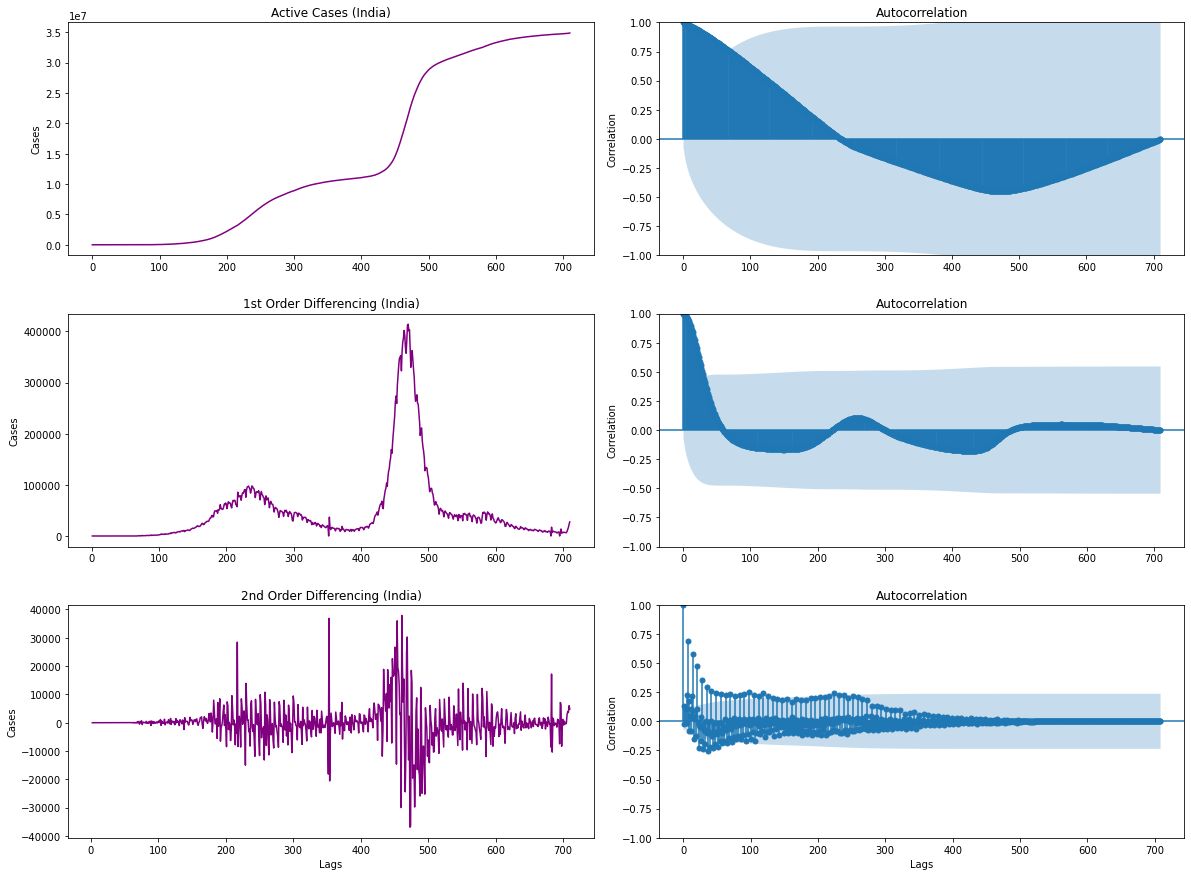

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.subplots_adjust(hspace=0.250, wspace=0.125)
axes[0, 0].plot(df, "purple")
axes[0, 0].set(title=f"Active Cases ({country})", ylabel="Cases")
plot_acf(df, ax=axes[0, 1], lags=df.shape[0] - 1)
axes[0, 1].set(ylabel="Correlation")

# 1st Differencing
axes[1, 0].plot(df.diff(), "purple")
axes[1, 0].set(title=f"1st Order Differencing ({country})", ylabel="Cases")
plot_acf(df.diff().dropna(), ax=axes[1, 1], lags=df.shape[0] - 2)
axes[1, 1].set(ylabel="Correlation")


# 2nd Differencing
axes[2, 0].plot(df.diff().diff(), "purple")
axes[2, 0].set(
    xlabel="Lags", ylabel="Cases", title=f"2nd Order Differencing ({country})"
)
axes[2, 1].set_xlabel("Lags")
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1], lags=df.shape[0] - 3)
axes[2, 1].set(ylabel="Correlation")

fig.savefig("Graphs/1.acf_plots.jpg")
plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the second differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.
$$d = 1 $$

### Determining order of Auto-Regression (p)

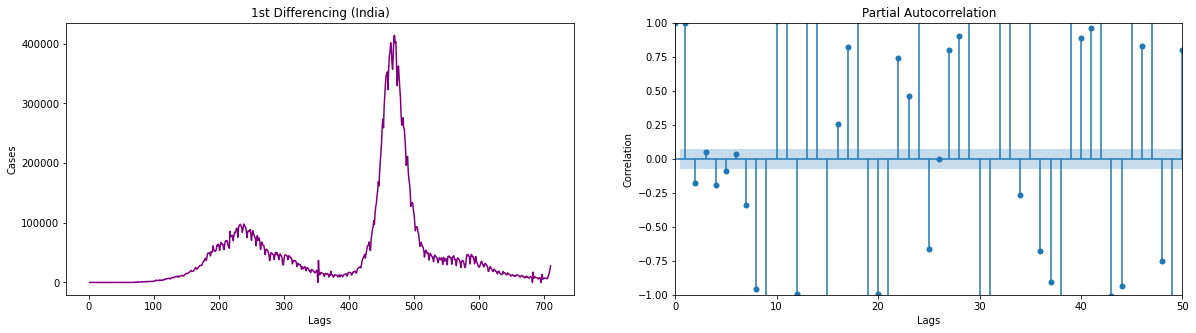

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(df.diff(), "purple")
ax1.set(title=f"1st Differencing ({country})", xlabel="Lags", ylabel="Cases")
plot_pacf(df.diff().dropna(), ax=ax2, lags=df.shape[0]/2 - 1)
ax2.set(xlabel="Lags", ylabel="Correlation", ylim=(-1, 1), xlim=(0, 50))
fig.savefig("Graphs/2.pacf_plots.jpg")
plt.show()

It can observed that the PACF lag 1 is quite significant since it is well above the significance limit, the blue region.
So we will use:
$$p = 1$$

### Determining order of Moving Average (q)

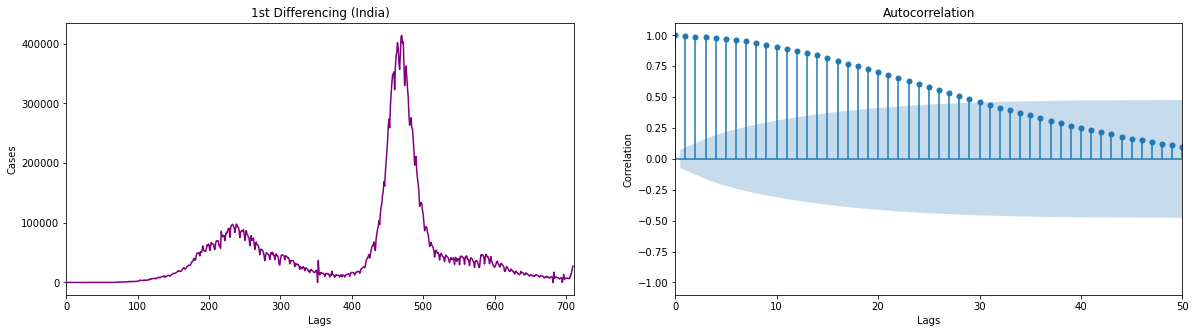

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(df.diff(), "purple")
axes[0].set(
    title=f"1st Differencing ({country})",
    xlabel="Lags",
    ylabel="Cases",
    xlim=(0, df.shape[0]),
)
plot_acf(df.diff().dropna(), ax=axes[1], lags=df.shape[0] - 2)
axes[1].set(ylim=(-1.1, 1.1), xlim=(0, 50), xlabel="Lags", ylabel="Correlation")

fig.savefig("Graphs/3.acf_plots.jpg")
plt.show()

We can see that upto `lags` = 16, the correlation is above the significance range and so we can conclude that: $$q \in [1, 28]$$

In [15]:
# Define the p, d, q parameters
p = range(1, 2)
d = range(1, 2)
q = range(1, 28)

In [17]:
pdq = list(itertools.product(p, d, q))
RMSE = []
ARIMA_model = []

for param in pdq:
    mod = sm.tsa.arima.ARIMA(df, order=param, enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit()
    print('ARIMA{} - RMSE:{}'.format(param, math.sqrt(results.mse)))
    RMSE.append(math.sqrt(results.mse))
    ARIMA_model.append(param)

ARIMA(1, 1, 1) - RMSE:6819.899226341465
ARIMA(1, 1, 2) - RMSE:6813.541940665654
ARIMA(1, 1, 3) - RMSE:6783.945139809925
ARIMA(1, 1, 4) - RMSE:6783.805378076497
ARIMA(1, 1, 5) - RMSE:6225.900070014395
ARIMA(1, 1, 6) - RMSE:6102.403778950589
ARIMA(1, 1, 7) - RMSE:5427.288089220827
ARIMA(1, 1, 8) - RMSE:5406.595537502121
ARIMA(1, 1, 9) - RMSE:5387.499871649451
ARIMA(1, 1, 10) - RMSE:5385.712005600168
ARIMA(1, 1, 11) - RMSE:5355.639667823899
ARIMA(1, 1, 12) - RMSE:5309.945869800822
ARIMA(1, 1, 13) - RMSE:5175.5843897333425
ARIMA(1, 1, 14) - RMSE:4944.172741783829
ARIMA(1, 1, 15) - RMSE:4966.454577803518
ARIMA(1, 1, 16) - RMSE:5008.942378238287
ARIMA(1, 1, 17) - RMSE:4962.060218658761
ARIMA(1, 1, 18) - RMSE:4887.461337725566
ARIMA(1, 1, 19) - RMSE:4864.689419722174
ARIMA(1, 1, 20) - RMSE:4725.345792201532
ARIMA(1, 1, 21) - RMSE:4534.936840104703
ARIMA(1, 1, 22) - RMSE:4494.162616572614
ARIMA(1, 1, 23) - RMSE:4482.300052386994
ARIMA(1, 1, 24) - RMSE:4480.43796016173
ARIMA(1, 1, 25) - RMSE:44

In [18]:
print('The smallest RMSE is {} for model ARIMA {}'.format(min(RMSE), ARIMA_model[RMSE.index(min(RMSE))]))

The smallest RMSE is 4465.9921138535565 for model ARIMA (1, 1, 27)


In [19]:
finalmod = sm.tsa.arima.ARIMA(df, order=ARIMA_model[RMSE.index(min(RMSE))], enforce_stationarity=False, enforce_invertibility=False)
results = finalmod.fit()

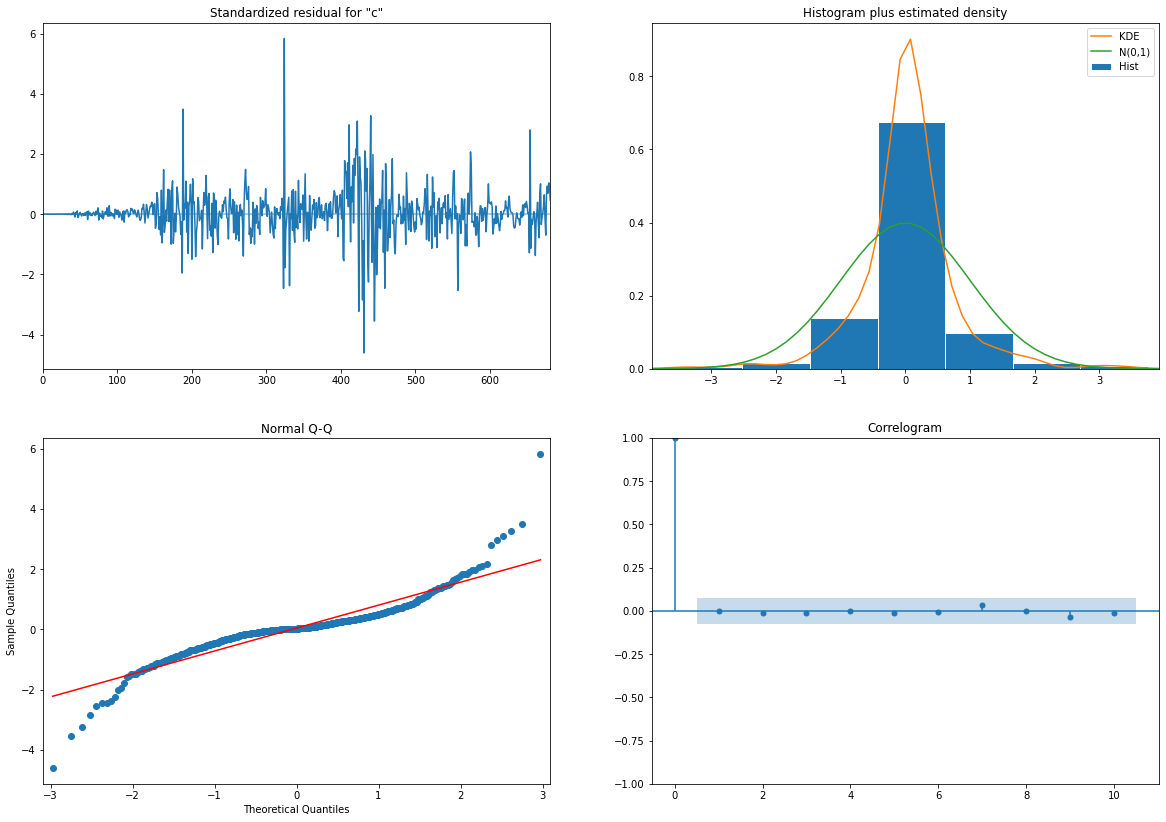

In [20]:
results.plot_diagnostics(figsize=(20, 14))
plt.savefig("Graphs/diagnostics_arima.jpg")
plt.show()

In [51]:
actual = pd.DataFrame((confirmed_df[country].to_numpy()), columns={"cases"})

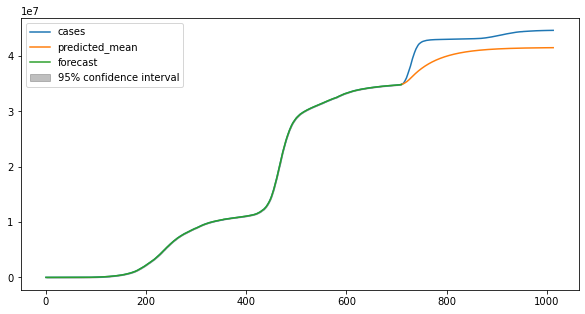

In [52]:
forecast = results.forecast(303)
ax = actual.plot(figsize=(10, 5))
forecast.plot(ax=ax)
pred = plot_predict(results, ax=ax, figsize=(10, 5))
pred
plt.savefig("Graphs/forecast_confirmed_india.jpg")
plt.show()